<a id='1'></a>
# Import packages

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
from keras.layers import *
import keras.backend as K
import tensorflow as tf

Using TensorFlow backend.


In [3]:
import os
import cv2
import glob
import time
import numpy as np
from pathlib import PurePath, Path
from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
tf.test.is_gpu_available()

True

In [5]:
tf.__version__

'1.7.0'

In [6]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [7]:
K.set_session(session)

<a id='4'></a>
# Config

In [8]:
K.set_learning_phase(1)
#K.set_learning_phase(0) # set to 0 in inference phase

In [9]:
# Number of CPU cores
num_cpus = os.cpu_count()

# Input/Output resolution
RESOLUTION = 128 # 64x64, 128x128, 256x256
assert (RESOLUTION % 64) == 0, "RESOLUTION should be 64, 128, or 256."

# Batch size
batchSize = 8
assert (batchSize != 1 and batchSize % 2 == 0) , "batchSize should be an even number."

# Use motion blurs (data augmentation)
# set True if training data contains images extracted from videos
use_da_motion_blur = True 

# Use eye-aware training
# require images generated from prep_binary_masks.ipynb
use_bm_eyes = True

# Probability of random color matching (data augmentation)
prob_random_color_match = 0.5

da_config = {
    "prob_random_color_match": prob_random_color_match,
    "use_da_motion_blur": use_da_motion_blur,
    "use_bm_eyes": use_bm_eyes
}

In [10]:
# Path to training images
img_dirA = 'data_faces/facesA/aligned_faces/'
img_dirB = 'data_faces/facesB/aligned_faces/'
img_dirA_bm_eyes = "data_faces/binary_masks/faceA_eyes"
img_dirB_bm_eyes = "data_faces/binary_masks/faceB_eyes"

# Path to saved model weights
models_dir = "weights_faces/gan_models"

In [11]:
# Architecture configuration
arch_config = {}
arch_config['IMAGE_SHAPE'] = (RESOLUTION, RESOLUTION, 3)
arch_config['use_self_attn'] = True
arch_config['norm'] = "instancenorm" # instancenorm, batchnorm, layernorm, groupnorm, none
arch_config['model_capacity'] = "standard" # standard, lite

In [12]:
# Loss function weights configuration
loss_weights = {}
loss_weights['w_D'] = 0.1 # Discriminator
loss_weights['w_recon'] = 1. # L1 reconstruction loss
loss_weights['w_edge'] = 0.1 # edge loss
loss_weights['w_eyes'] = 30. # reconstruction and edge loss on eyes area
loss_weights['w_pl'] = (0.01, 0.1, 0.3, 0.1) # perceptual loss (0.003, 0.03, 0.3, 0.3)

# Init. loss config.
loss_config = {}
loss_config["gan_training"] = "mixup_LSGAN" # "mixup_LSGAN" or "relativistic_avg_LSGAN"
loss_config['use_PL'] = False
loss_config["PL_before_activ"] = False
loss_config['use_mask_hinge_loss'] = False
loss_config['m_mask'] = 0.
loss_config['lr_factor'] = 1.
loss_config['use_cyclic_loss'] = False

<a id='5'></a>
# Define models

In [13]:
from scripts_faces.networks.faceswap_gan_model import FaceswapGANModel

Instructions for updating:
Use the retry module or similar alternatives.


In [14]:
model = FaceswapGANModel(**arch_config)

<a id='6'></a>
# Load Model Weights

Weights file names:
```python
encoder.h5, decoder_A.h5, deocder_B.h5, netDA.h5, netDB.h5
```

In [15]:
# model.load_weights(path=models_dir)

### The following cells are for training, skip to [transform_face()](#tf) for inference.

# Define Losses and Build Training Functions

TODO: split into two methods

In [16]:
# https://github.com/rcmalli/keras-vggface
#!pip install keras_vggface --no-dependencies
from keras_vggface.vggface import VGGFace

# VGGFace ResNet50
vggface = VGGFace(include_top=False, model='resnet50', input_shape=(224, 224, 3))

#vggface.summary()

model.build_pl_model(vggface_model=vggface, before_activ=loss_config["PL_before_activ"])

94699520/94694792 [==============================] - 61s 1us/step


In [17]:
model.build_train_functions(loss_weights=loss_weights, **loss_config)

<a id='9'></a>
# DataLoader

In [18]:
from scripts_faces.data_loader.data_loader import DataLoader

# Visualizer

TODO: write a Visualizer class

In [19]:
from scripts_faces.utils import showG, showG_mask, showG_eyes

<a id='10'></a>
# Start Training
TODO: make training script compact

In [20]:
# Create ./models directory
Path(f"weights_faces/gan_models").mkdir(parents=True, exist_ok=True)

In [21]:
# Get filenames
train_A = glob.glob(img_dirA+"/*.*")
train_B = glob.glob(img_dirB+"/*.*")

train_AnB = train_A + train_B

assert len(train_A), "No image found in " + str(img_dirA)
assert len(train_B), "No image found in " + str(img_dirB)
print ("Number of images in folder A: " + str(len(train_A)))
print ("Number of images in folder B: " + str(len(train_B)))

if use_bm_eyes:
    assert len(glob.glob(img_dirA_bm_eyes+"/*.*")), "No binary mask found in " + str(img_dirA_bm_eyes)
    assert len(glob.glob(img_dirB_bm_eyes+"/*.*")), "No binary mask found in " + str(img_dirB_bm_eyes)
    assert len(glob.glob(img_dirA_bm_eyes+"/*.*")) == len(train_A), \
    "Number of faceA images does not match number of their binary masks. Can be caused by any none image file in the folder."
    assert len(glob.glob(img_dirB_bm_eyes+"/*.*")) == len(train_B), \
    "Number of faceB images does not match number of their binary masks. Can be caused by any none image file in the folder."

Number of images in folder A: 3644
Number of images in folder B: 7114


In [22]:
def show_loss_config(loss_config):
    for config, value in loss_config.items():
        print(f"{config} = {value}")

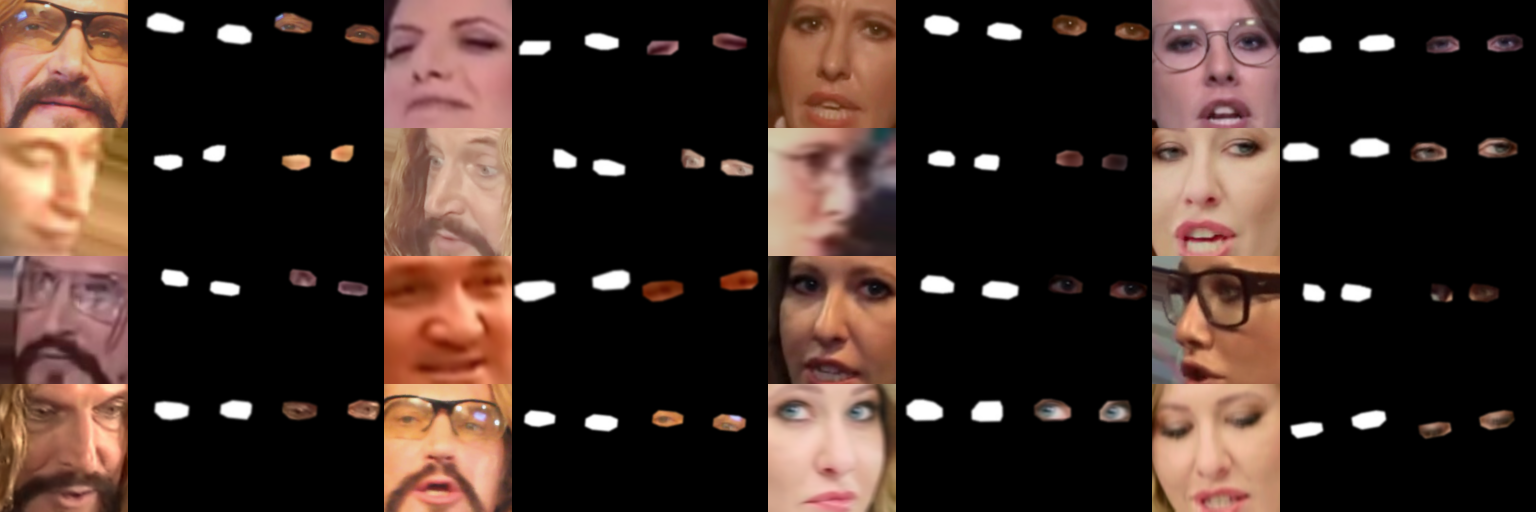

In [24]:
# Display random binary masks of eyes
train_batchA = DataLoader(train_A, train_AnB, batchSize, img_dirA_bm_eyes, 
                          RESOLUTION, num_cpus, K.get_session(), **da_config)
train_batchB = DataLoader(train_B, train_AnB, batchSize, img_dirB_bm_eyes, 
                          RESOLUTION, num_cpus, K.get_session(), **da_config)
_, tA, bmA = train_batchA.get_next_batch()
_, tB, bmB = train_batchB.get_next_batch()
showG_eyes(tA, tB, bmA, bmB, batchSize)
del train_batchA, train_batchB

In [25]:
def reset_session(save_path):
    global model, vggface
    global train_batchA, train_batchB
    model.save_weights(path=save_path)
    del model
    del vggface
    del train_batchA
    del train_batchB
    K.clear_session()
    model = FaceswapGANModel(**arch_config)
    model.load_weights(path=save_path)
    vggface = VGGFace(include_top=False, model='resnet50', input_shape=(224, 224, 3))
    model.build_pl_model(vggface_model=vggface, before_activ=loss_config["PL_before_activ"])
    train_batchA = DataLoader(train_A, train_AnB, batchSize, img_dirA_bm_eyes,
                              RESOLUTION, num_cpus, K.get_session(), **da_config)
    train_batchB = DataLoader(train_B, train_AnB, batchSize, img_dirB_bm_eyes, 
                              RESOLUTION, num_cpus, K.get_session(), **da_config)

In [26]:
import keras

In [27]:
# model.encoder = keras.utils.multi_gpu_model(model.encoder, gpus=2)
# model.decoder_A = keras.utils.multi_gpu_model(model.decoder_A, gpus=2)
# model.decoder_B = keras.utils.multi_gpu_model(model.decoder_B, gpus=2)
# model.netDA = keras.utils.multi_gpu_model(model.netDA, gpus=2)
# model.netDB = keras.utils.multi_gpu_model(model.netDB, gpus=2)

In [28]:
# gen_iterations = 3000

In [ ]:
# Start training
t0 = time.time()

# This try/except is meant to resume training that was accidentally interrupted
try:
    gen_iterations
    print(f"Resume training from iter {gen_iterations}.")
except:
    gen_iterations = 0

errGA_sum = errGB_sum = errDA_sum = errDB_sum = 0
errGAs = {}
errGBs = {}
# Dictionaries are ordered in Python 3.6
for k in ['ttl', 'adv', 'recon', 'edge', 'pl']:
    errGAs[k] = 0
    errGBs[k] = 0

display_iters = 300
backup_iters = 5000
TOTAL_ITERS = 40000

global train_batchA, train_batchB
train_batchA = DataLoader(train_A, train_AnB, batchSize, img_dirA_bm_eyes, 
                          RESOLUTION, num_cpus, K.get_session(), **da_config)
train_batchB = DataLoader(train_B, train_AnB, batchSize, img_dirB_bm_eyes, 
                          RESOLUTION, num_cpus, K.get_session(), **da_config)

while gen_iterations <= TOTAL_ITERS: 
    
    # Loss function automation
    if gen_iterations == (TOTAL_ITERS//5 - display_iters//2):
        clear_output()
        loss_config['use_PL'] = True
        loss_config['use_mask_hinge_loss'] = False
        loss_config['m_mask'] = 0.0
        reset_session(models_dir)
        print("Building new loss funcitons...")
        show_loss_config(loss_config)
        model.build_train_functions(loss_weights=loss_weights, **loss_config)
        print("Done.")
    elif gen_iterations == (TOTAL_ITERS//5 + TOTAL_ITERS//10 - display_iters//2):
        clear_output()
        loss_config['use_PL'] = True
        loss_config['use_mask_hinge_loss'] = True
        loss_config['m_mask'] = 0.5
        reset_session(models_dir)
        print("Building new loss funcitons...")
        show_loss_config(loss_config)
        model.build_train_functions(loss_weights=loss_weights, **loss_config)
        print("Complete.")
    elif gen_iterations == (2*TOTAL_ITERS//5 - display_iters//2):
        clear_output()
        loss_config['use_PL'] = True
        loss_config['use_mask_hinge_loss'] = True
        loss_config['m_mask'] = 0.2
        reset_session(models_dir)
        print("Building new loss funcitons...")
        show_loss_config(loss_config)
        model.build_train_functions(loss_weights=loss_weights, **loss_config)
        print("Done.")
    elif gen_iterations == (TOTAL_ITERS//2 - display_iters//2):
        clear_output()
        loss_config['use_PL'] = True
        loss_config['use_mask_hinge_loss'] = True
        loss_config['m_mask'] = 0.4
        reset_session(models_dir)
        print("Building new loss funcitons...")
        show_loss_config(loss_config)
        model.build_train_functions(loss_weights=loss_weights, **loss_config)
        print("Done.")
    elif gen_iterations == (2*TOTAL_ITERS//3 - display_iters//2):
        clear_output()
        loss_config['use_PL'] = True
        loss_config['use_mask_hinge_loss'] = False
        loss_config['m_mask'] = 0.
        loss_config['lr_factor'] = 0.3
        reset_session(models_dir)
        print("Building new loss funcitons...")
        show_loss_config(loss_config)
        model.build_train_functions(loss_weights=loss_weights, **loss_config)
        print("Done.")
    elif gen_iterations == (8*TOTAL_ITERS//10 - display_iters//2):
        clear_output()
        model.decoder_A.load_weights("models/decoder_B.h5") # swap decoders
        model.decoder_B.load_weights("models/decoder_A.h5") # swap decoders
        loss_config['use_PL'] = True
        loss_config['use_mask_hinge_loss'] = True
        loss_config['m_mask'] = 0.1
        loss_config['lr_factor'] = 0.3
        reset_session(models_dir)
        print("Building new loss funcitons...")
        show_loss_config(loss_config)
        model.build_train_functions(loss_weights=loss_weights, **loss_config)
        print("Done.")
    elif gen_iterations == (9*TOTAL_ITERS//10 - display_iters//2):
        clear_output()
        loss_config['use_PL'] = True
        loss_config['use_mask_hinge_loss'] = False
        loss_config['m_mask'] = 0.0
        loss_config['lr_factor'] = 0.1
        reset_session(models_dir)
        print("Building new loss funcitons...")
        show_loss_config(loss_config)
        model.build_train_functions(loss_weights=loss_weights, **loss_config)
        print("Done.")
    
    if gen_iterations == 5:
        print ("working.")
    
    # Train dicriminators for one batch
    data_A = train_batchA.get_next_batch()
    data_B = train_batchB.get_next_batch()
    errDA, errDB = model.train_one_batch_D(data_A=data_A, data_B=data_B)
    errDA_sum +=errDA[0]
    errDB_sum +=errDB[0]

    # Train generators for one batch
    data_A = train_batchA.get_next_batch()
    data_B = train_batchB.get_next_batch()
    errGA, errGB = model.train_one_batch_G(data_A=data_A, data_B=data_B)
    errGA_sum += errGA[0]
    errGB_sum += errGB[0]
    for i, k in enumerate(['ttl', 'adv', 'recon', 'edge', 'pl']):
        errGAs[k] += errGA[i]
        errGBs[k] += errGB[i]
    gen_iterations+=1
    
    # Visualization
    if gen_iterations % display_iters == 0:
        clear_output()
            
        # Display loss information
        show_loss_config(loss_config)
        print("----------") 
        print('[iter %d] Loss_DA: %f Loss_DB: %f Loss_GA: %f Loss_GB: %f time: %f'
        % (gen_iterations, errDA_sum/display_iters, errDB_sum/display_iters,
           errGA_sum/display_iters, errGB_sum/display_iters, time.time()-t0))  
        print("----------") 
        print("Generator loss details:")
        print(f'[Adversarial loss]')  
        print(f'GA: {errGAs["adv"]/display_iters:.4f} GB: {errGBs["adv"]/display_iters:.4f}')
        print(f'[Reconstruction loss]')
        print(f'GA: {errGAs["recon"]/display_iters:.4f} GB: {errGBs["recon"]/display_iters:.4f}')
        print(f'[Edge loss]')
        print(f'GA: {errGAs["edge"]/display_iters:.4f} GB: {errGBs["edge"]/display_iters:.4f}')
        if loss_config['use_PL'] == True:
            print(f'[Perceptual loss]')
            try:
                print(f'GA: {errGAs["pl"][0]/display_iters:.4f} GB: {errGBs["pl"][0]/display_iters:.4f}')
            except:
                print(f'GA: {errGAs["pl"]/display_iters:.4f} GB: {errGBs["pl"]/display_iters:.4f}')
        
        # Display images
        print("----------") 
        wA, tA, _ = train_batchA.get_next_batch()
        wB, tB, _ = train_batchB.get_next_batch()
        try:
            print("Transformed (masked) results:")
            showG(tA, tB, model.path_A, model.path_B, batchSize)   
            print("Masks:")
            showG_mask(tA, tB, model.path_mask_A, model.path_mask_B, batchSize)  
            print("Reconstruction results:")
            showG(wA, wB, model.path_bgr_A, model.path_bgr_B, batchSize)
        except:
            pass
        errGA_sum = errGB_sum = errDA_sum = errDB_sum = 0
        for k in ['ttl', 'adv', 'recon', 'edge', 'pl']:
            errGAs[k] = 0
            errGBs[k] = 0
        
        # Save models
        model.save_weights(path=models_dir)
    
    # Backup models
    if gen_iterations % backup_iters == 0: 
        bkup_dir = f"{models_dir}/backup_iter{gen_iterations}"
        Path(bkup_dir).mkdir(parents=True, exist_ok=True)
        model.save_weights(path=bkup_dir)

working.


In [ ]:
gen_iterations

Transformed (masked) results:


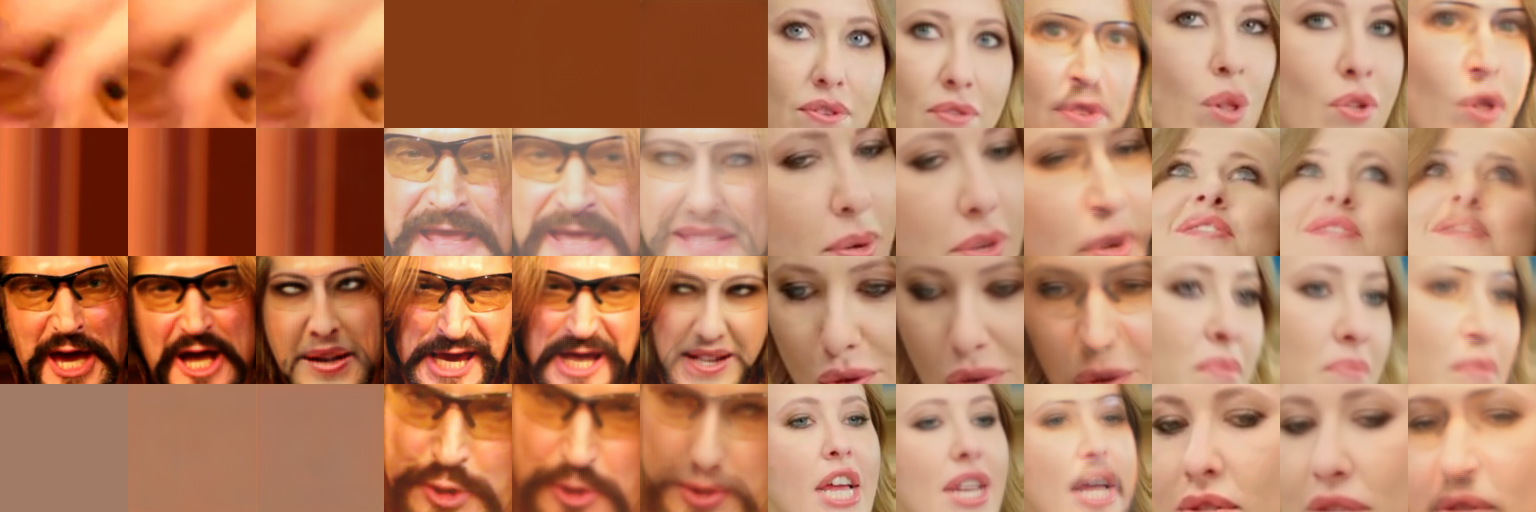

Masks:


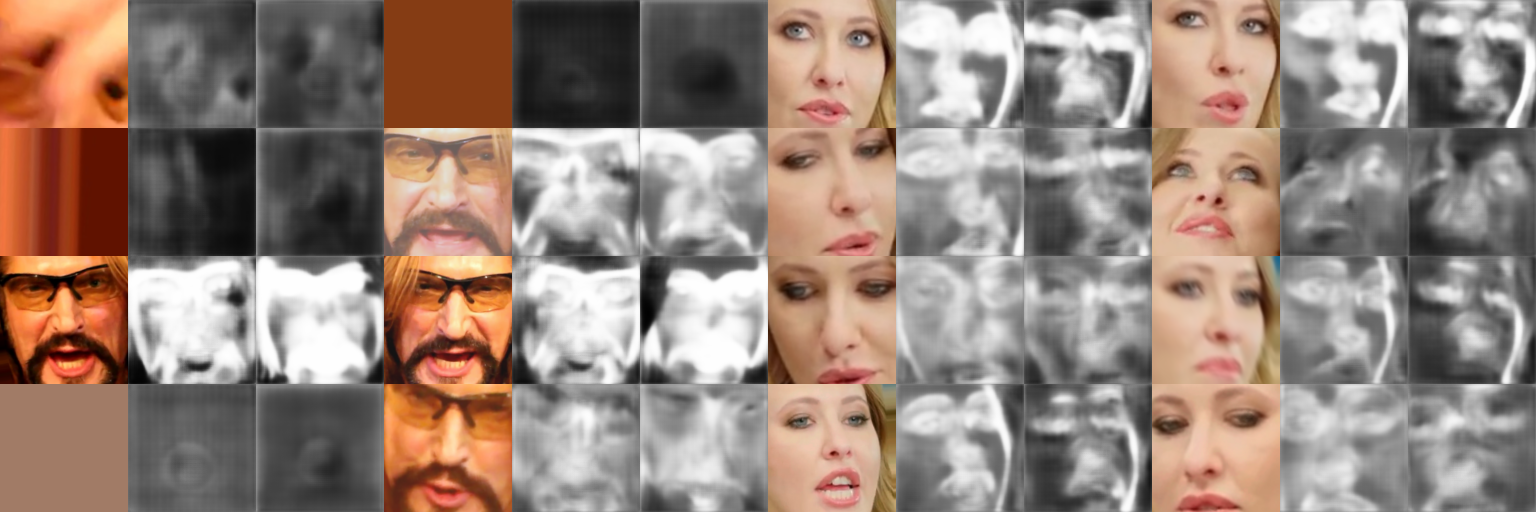

Reconstruction results:


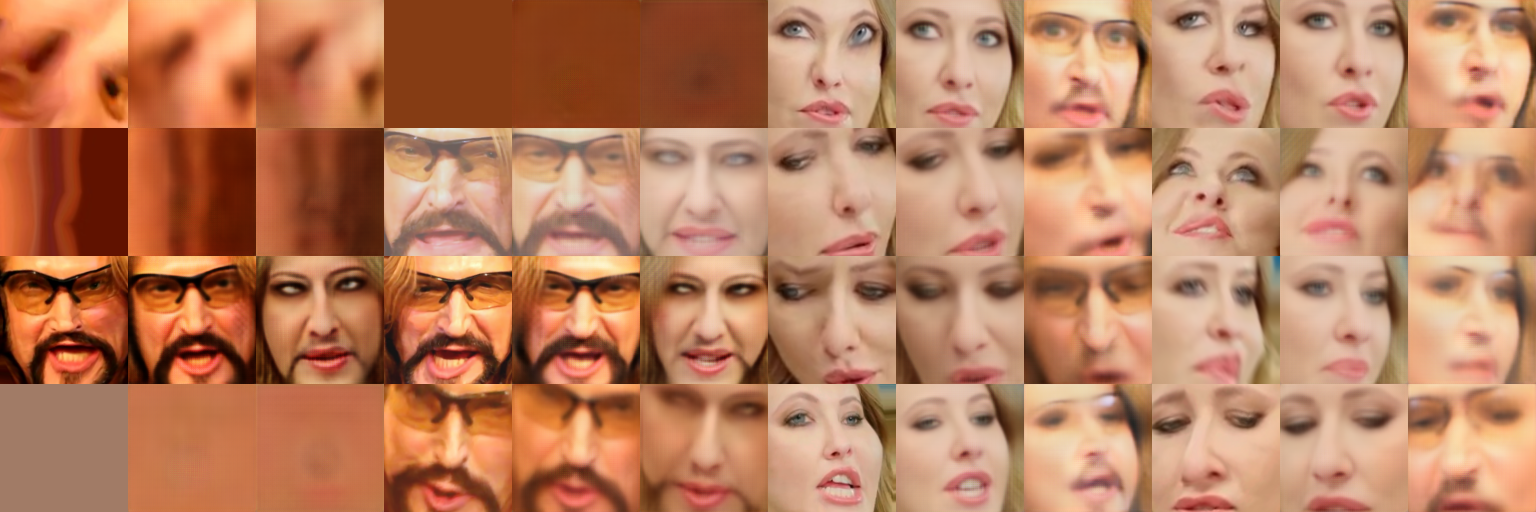

In [36]:
# Display random results
wA, tA, _ = train_batchA.get_next_batch()
wB, tB, _ = train_batchB.get_next_batch()
print("Transformed (masked) results:")
showG(tA, tB, model.path_A, model.path_B, batchSize)   
print("Masks:")
showG_mask(tA, tB, model.path_mask_A, model.path_mask_B, batchSize)  
print("Reconstruction results:")
showG(wA, wB, model.path_bgr_A, model.path_bgr_B, batchSize) 

# (Optional) Additional 40k iterations of training

In [ ]:
# """
loss_config['use_PL'] = True
loss_config['use_mask_hinge_loss'] = False
loss_config['m_mask'] = 0.0
loss_config['lr_factor'] = 0.1
reset_session(models_dir)
print("Building new loss funcitons...")
show_loss_config(loss_config)
model.build_train_functions(loss_weights=loss_weights, **loss_config)
# """

In [ ]:
# """
# Start training
t0 = time.time()
gen_iterations = 0
errGA_sum = errGB_sum = errDA_sum = errDB_sum = 0
errGAs = {}
errGBs = {}
# Dictionaries are ordered in Python 3.6
for k in ['ttl', 'adv', 'recon', 'edge', 'pl']:
    errGAs[k] = 0
    errGBs[k] = 0

display_iters = 300
backup_iters = 5000
TOTAL_ITERS = 20000

global train_batchA, train_batchB
train_batchA = DataLoader(train_A, train_AnB, batchSize, img_dirA_bm_eyes, 
                          RESOLUTION, num_cpus, K.get_session(), **da_config)
train_batchB = DataLoader(train_B, train_AnB, batchSize, img_dirB_bm_eyes, 
                          RESOLUTION, num_cpus, K.get_session(), **da_config)

while gen_iterations <= TOTAL_ITERS: 
    
    if gen_iterations == 5:
        print ("working.")
    
    # Train dicriminators for one batch
    data_A = train_batchA.get_next_batch()
    data_B = train_batchB.get_next_batch()
    errDA, errDB = model.train_one_batch_D(data_A=data_A, data_B=data_B)
    errDA_sum +=errDA[0]
    errDB_sum +=errDB[0]

    # Train generators for one batch
    data_A = train_batchA.get_next_batch()
    data_B = train_batchB.get_next_batch()
    errGA, errGB = model.train_one_batch_G(data_A=data_A, data_B=data_B)
    errGA_sum += errGA[0]
    errGB_sum += errGB[0]
    for i, k in enumerate(['ttl', 'adv', 'recon', 'edge', 'pl']):
        errGAs[k] += errGA[i]
        errGBs[k] += errGB[i]
    gen_iterations+=1
    
    # Visualization
    if gen_iterations % display_iters == 0:
        clear_output()
            
        # Display loss information
        show_loss_config(loss_config)
        print("----------") 
        print('[iter %d] Loss_DA: %f Loss_DB: %f Loss_GA: %f Loss_GB: %f time: %f'
        % (gen_iterations, errDA_sum/display_iters, errDB_sum/display_iters,
           errGA_sum/display_iters, errGB_sum/display_iters, time.time()-t0))  
        print("----------") 
        print("Generator loss details:")
        print(f'[Adversarial loss]')  
        print(f'GA: {errGAs["adv"]/display_iters:.4f} GB: {errGBs["adv"]/display_iters:.4f}')
        print(f'[Reconstruction loss]')
        print(f'GA: {errGAs["recon"]/display_iters:.4f} GB: {errGBs["recon"]/display_iters:.4f}')
        print(f'[Edge loss]')
        print(f'GA: {errGAs["edge"]/display_iters:.4f} GB: {errGBs["edge"]/display_iters:.4f}')
        if loss_config['use_PL'] == True:
            print(f'[Perceptual loss]')
            try:
                print(f'GA: {errGAs["pl"][0]/display_iters:.4f} GB: {errGBs["pl"][0]/display_iters:.4f}')
            except:
                print(f'GA: {errGAs["pl"]/display_iters:.4f} GB: {errGBs["pl"]/display_iters:.4f}')
        
        # Display images
        print("----------") 
        wA, tA, _ = train_batchA.get_next_batch()
        wB, tB, _ = train_batchB.get_next_batch()
        print("Transformed (masked) results:")
        showG(tA, tB, model.path_A, model.path_B, batchSize)   
        print("Masks:")
        showG_mask(tA, tB, model.path_mask_A, model.path_mask_B, batchSize)  
        print("Reconstruction results:")
        showG(wA, wB, model.path_bgr_A, model.path_bgr_B, batchSize)           
        errGA_sum = errGB_sum = errDA_sum = errDB_sum = 0
        for k in ['ttl', 'adv', 'recon', 'edge', 'pl']:
            errGAs[k] = 0
            errGBs[k] = 0
        
        # Save models
        model.save_weights(path=models_dir)
    
    # Backup models
    if gen_iterations % backup_iters == 0: 
        bkup_dir = f"{models_dir}/backup_iter{gen_iterations}"
        Path(bkup_dir).mkdir(parents=True, exist_ok=True)
        model.save_weights(path=bkup_dir)
# """

<a id='tf'></a>
# Single Image Transformation

In [12]:
from detector.face_detector import MTCNNFaceDetector
from converter.landmarks_alignment import *

In [13]:
mtcnn_weights_dir = "./mtcnn_weights/"
fd = MTCNNFaceDetector(sess=K.get_session(), model_path=mtcnn_weights_dir)

In [14]:
def shift_n_scale(src_img, tar_img):
    """
    A color correction method
    """
    src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2XYZ)
    tar_img = cv2.cvtColor(tar_img, cv2.COLOR_BGR2XYZ)    
    mt = np.mean(tar_img, axis=(0,1))
    st = np.std(tar_img, axis=(0,1))
    ms = np.mean(src_img, axis=(0,1))
    ss = np.std(src_img, axis=(0,1))    
    if ss.any() <= 1e-7: return src_img    
    result = st * (src_img.astype(np.float32) - ms) / (ss+1e-7) + mt
    result = (255.0 / result.max() * result).astype(np.float32)    
    result = cv2.cvtColor(result.astype(np.uint8), cv2.COLOR_XYZ2BGR)
    return result

def transform_face(inp_img, direction="AtoB", roi_coef=15, color_correction=True):
    """
    Parameters:
        inp_img: A RGB face image of any size.
        direction:  A string that is either AtoB or BtoA
        roi_coef: A coefficient that affects the cropped center area
        color_correction: boolean, whether use color correction or not
    Returns:
        result_img: A RGB swapped face image after masking.
        result_mask: The alpha mask which corresponds to the result_img.
    """
    def get_feather_edges_mask(img, roi_coef):
        img_size = img.shape
        mask = np.zeros_like(img)
        x_, y_ = img_size[0]//roi_coef, img_size[1]//roi_coef
        mask[x_:-x_, y_:-y_,:]  = 255
        mask = cv2.GaussianBlur(mask,(15,15),10).astype(np.float32) / 255
        return mask        

    if direction == "AtoB":
        path_func = model.path_abgr_B
    elif direction == "BtoA":
        path_func = model.path_abgr_A
    else:
        raise ValueError(f"direction should be either AtoB or BtoA, recieved {direction}.")

    # pre-process input image
    img_bgr = cv2.cvtColor(inp_img, cv2.COLOR_RGB2BGR)
    input_size = img_bgr.shape    
    roi_x, roi_y = input_size[0]//roi_coef, input_size[1]//roi_coef
    roi = img_bgr[roi_x:-roi_x, roi_y:-roi_y,:] # BGR, [0, 255]  
    roi_size = roi.shape
    ae_input = cv2.resize(roi, (RESOLUTION,RESOLUTION)) / 255. * 2 - 1 # BGR, [-1, 1]       

    # post-process transformed roi image
    ae_output = np.squeeze(np.array([path_func([[ae_input]])]))
    ae_output_a = ae_output[:,:,0] * 255
    ae_output_a = cv2.resize(ae_output_a, (roi_size[1],roi_size[0]))[...,np.newaxis]
    ae_output_bgr = np.clip( (ae_output[:,:,1:] + 1) * 255 / 2, 0, 255)
    ae_output_bgr = cv2.resize(ae_output_bgr, (roi_size[1],roi_size[0]))
    ae_output_masked = (ae_output_a/255 * ae_output_bgr + (1 - ae_output_a/255) * roi).astype('uint8') # BGR, [0, 255]
    if color_correction:
        ae_output_masked = shift_n_scale(ae_output_masked, roi)

    # merge transformed output back to input image
    blend_mask = get_feather_edges_mask(roi, roi_coef)        
    blended_img = blend_mask * ae_output_masked + (1 - blend_mask) * roi
    result = img_bgr
    result[roi_x:-roi_x, roi_y:-roi_y,:] = blended_img 
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB) 
    result_alpha = np.zeros_like(img_bgr)
    result_alpha[roi_x:-roi_x, roi_y:-roi_y,:] = blend_mask * ae_output_a 
    return result, result_alpha

In [15]:
# Read input image
input_img = plt.imread(glob.glob('test/*')[0])[...,:3]

if input_img.dtype == np.float32:
    print("input_img has dtype np.float32 (perhaps the image format is PNG). Scale it to uint8.")
    input_img = (input_img * 255).astype(np.uint8)

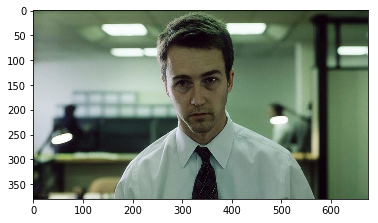

In [16]:
# Display input image
plt.imshow(input_img)

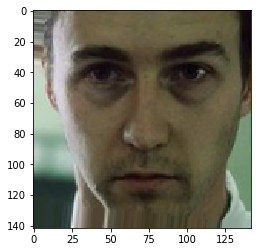

In [17]:
# Display detected face
face, lms = fd.detect_face(input_img)
if len(face) == 1:
    x0, y1, x1, y0, _ = face[0]
    det_face_im = input_img[int(x0):int(x1),int(y0):int(y1),:]
    try:
        src_landmarks = get_src_landmarks(x0, x1, y0, y1, lms)
        tar_landmarks = get_tar_landmarks(det_face_im)
        aligned_det_face_im = landmarks_match_mtcnn(det_face_im, src_landmarks, tar_landmarks)
    except:
        print("An error occured during face alignment.")
        aligned_det_face_im = det_face_im
elif len(face) == 0:
    raise ValueError("Error: no face detected.")
elif len(face) > 1:
    print (face)
    raise ValueError("Error: multiple faces detected")
    
plt.imshow(aligned_det_face_im)

In [18]:
# Transform detected face
result_img, result_mask = transform_face(aligned_det_face_im, direction="AtoB", roi_coef=15)
try:
    result_img = landmarks_match_mtcnn(result_img, tar_landmarks, src_landmarks)
    result_mask = landmarks_match_mtcnn(result_mask, tar_landmarks, src_landmarks)
except:
    print("An error occured during face alignment.")
    pass

result_input_img = input_img.copy()
result_input_img[int(x0):int(x1),int(y0):int(y1),:] = result_mask.astype(np.float32)/255*result_img +\
(1-result_mask.astype(np.float32)/255)*result_input_img[int(x0):int(x1),int(y0):int(y1),:]

NameError: name 'model' is not defined

In [ ]:
# Display transformed image
plt.imshow(result_img)

In [ ]:
# Display alpha mask
plt.imshow(result_mask[..., 0])

In [ ]:
# Display interpolations before/after transformation
def interpolate_imgs(im1, im2):
    im1, im2 = map(np.float32, [im1, im2])
    out = [ratio * im1 + (1-ratio) * im2 for ratio in np.linspace(1, 0, 5)]
    out = map(np.uint8, out)
    return out

plt.figure(figsize=(15,8))
plt.imshow(np.hstack(interpolate_imgs(input_img, result_input_img)))